# 🧠 Concept Bottleneck Models (CBM)
**Hands-On Tutorial Notebook – ECML PKDD 2025 ‘An Overview to Concept-based Explainable AI’**  

*Based on* : Koh, Pang Wei, *et al.*  [Concept Bottleneck Models](https://proceedings.mlr.press/v119/koh20a/koh20a.pdf), ICML 2020.

*Official repo*: https://github.com/yewsiang/ConceptBottleneck  

<a target="_blank" href="https://colab.research.google.com/github/cxai-mechint-htutorial-kdd2025/cxai-mechint-htutorial-kdd2025.github.io/blob/main/notebooks/02a_cbm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---

### 🌟 **What you will learn**
1. Train and evaluate a **Concept Bottleneck Model** using intermediate concepts.
2. Inspect **concept-based explanations** and control predictions via concept **intervention**.

**Estimated runtime** (Colab, cpu): ≈ 10 min

## 🗺️ Notebook RoadMap
1. ⚙️ **Environment Setup**
2. 🧹 **Prepare the Dataset**
3. 🏗️ **Build the Concept Bottleneck Model**
4. 🧮 **Setup Training Components**
5. 🧪 **Train and Evaluate the Model**
6. 📊 **Visualize Predictions**
7. 👩🏻‍🔬 **Concept Intervention**

![CBM pipeline](https://raw.githubusercontent.com/cxai-mechint-htutorial-kdd2025/cxai-mechint-htutorial-kdd2025.github.io/refs/heads/main/img_notebooks/cbm.png)

# 1. ⚙️ Environment Setup

👉🏻 Run the cell below on Colab to install the requirements.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

import random
random.seed(seed_value)

# 2. 🧹 Prepare the Dataset

To train a Concept Bottleneck Model, we need a dataset that includes:

- **Input images**

- **Concept labels** (interpretable features like the digit class)

- **Task labels** (the final prediction target, like even/odd)

In this step, you’ll create a custom subclass of the standard MNIST dataset to annotate each image with both:

- Its **digit** -> used as a **concept**

- Whether the digit is **even or odd** -> used as the **task label**

🔧 Custom Dataset Class: `MNISTEvenOdd`

The `MNISTEvenOdd` class:

- Inherits from `torchvision.datasets.MNIST`.

- Applies standard normalization and expands grayscale images to 3 channels to be compatible with models like ResNet.

- Reduces the dataset size to 10,000 samples for quicker experimentation.

- Returns a tuple of:

  - `img`: the input image

  - `concept`: the digit label (0–9)

  - `task`: binary label (0 for even, 1 for odd)

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.01MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


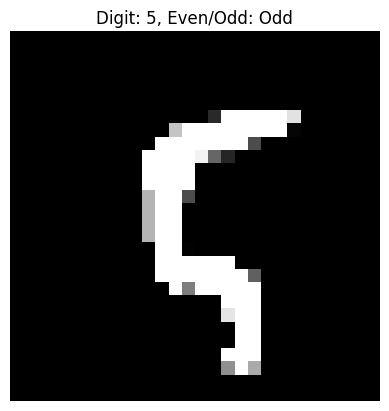

In [2]:
class MNISTEvenOdd(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, download=True):
        # Define the transformation pipeline
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),             # Normalize using MNIST stats
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))          # Convert 1-channel to 3-channel
        ])

        # Initialize base MNIST class with custom transforms
        super().__init__(root=root, train=train, transform=transform, download=download)

        # ⚠️ Subsample for quick experimentation (10,000 examples)
        self.data = self.data[:10_000]
        self.targets = self.targets[:10_000]

    def __getitem__(self, index):
        # Get base image and label
        img, label = super().__getitem__(index)

        # Define the digit as concept label
        concept = label

        # Define the even/odd binary label as task
        task = label % 2

        return img, concept, task

# 🗃️ Instantiate Datasets
train_dataset = MNISTEvenOdd(root='.', train=True)
test_dataset = MNISTEvenOdd(root='.', train=False)

# 🔍 Visualize a Sample
image, concept, task = train_dataset[100]

plt.imshow(image.permute(1, 2, 0).squeeze().numpy(), cmap='gray')
plt.title(f"Digit: {concept}, Even/Odd: {'Odd' if task == 1 else 'Even'}")
plt.axis('off')
plt.show()

# 3. 🏗️ Build the Concept Bottleneck Model

In this step, you will build a **Concept Bottleneck Model (CBM)** composed of three main components:

1. A shared **feature extractor** based on a pretrained ResNet18 (minus its final classifier).

2. A **concept classifier** that predicts the digit class (0–9) from the extracted features.

3. A **task classifier** that predicts whether the digit is even or odd, using only the predicted concept logits as input.

This architecture enforces an **interpretable bottleneck**: the even/odd decision must be made based on intermediate concept activations (i.e., the digit identity), which allows for **editable, explainable decision-making**.

In [3]:
class CBM(nn.Module):
    def __init__(self, num_concepts=10, num_classes=2):
        super().__init__()

        # 🎯 Feature extractor: ResNet18 (remove final classifier)
        self.backbone = torchvision.models.resnet18(pretrained=False)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # 🔢 Concept classifier (predict digit class)
        self.concept_classifier = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, num_concepts),
        )

        # Final predictor: maps concepts to final output classes
        self.task_classifier = nn.Sequential(
            nn.Linear(num_concepts, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )


    def forward(self, x):
        features = self.backbone(x)                      # Extract deep features
        concepts = self.concept_classifier(features)     # Predict digit class (concepts)
        task_logits = self.task_classifier(concepts)     # Predict even/odd from concepts
        return concepts, task_logits

# 🧪 Instantiate the model and evaluate on a sample image
model = CBM()
model.eval()

# Run a forward pass on one image
digit_logits, even_odd_logits = model(image.unsqueeze(0))

# Display the shape and logits
print("Digit prediction logits:", digit_logits.shape, digit_logits.detach().numpy().round(2))
print("Even/Odd prediction logits:", even_odd_logits.shape, even_odd_logits.detach().numpy().round(2))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Digit prediction logits: torch.Size([1, 10]) [[-0.06  0.03 -0.01 -0.15 -0.06 -0.25  0.15 -0.09  0.03  0.09]]
Even/Odd prediction logits: torch.Size([1, 2]) [[-0.1   0.01]]


# 4. 🧮 Setup Training Components

Now that you have defined your Concept Bottleneck Model (CBM), it's time to prepare the training setup. This includes:

1. **Dataloaders** for batching and shuffling the dataset.

2. A **loss function** to optimize both concept and task predictions. We'll use the `CrossEntropyLoss` for digit classification for the concepts  and for even/odd prediction (binary) for the taks.

3. An **optimizer** to update the model weights. `Adam` is used for its efficiency and adaptive learning rate.

4. Selecting the appropriate **device** (GPU if available).

In [4]:
# 🔧 Hyperparameters
batch_size = 128
num_epochs = 2
learning_rate = 0.001

# 🧪 Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 🎯 Loss Function
criterion = nn.CrossEntropyLoss()

# 🚀 Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 🖥️ Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Model is ready for training on: {device}")

✅ Model is ready for training on: cpu


# 5. 🧪 Train and Evaluate the Model

In this step, you'll train the Concept Bottleneck Model (CBM) using two supervision:

- **Concept supervision**: Predicting the digit identity (0–9)

- **Task supervision**: Predicting if the digit is even or odd

To encourage the model *to rely on the concepts when making task predictions*, we compute:

- A **concept loss**: using the digit prediction

- A **task loss**: using the even/odd prediction from the concept logits
These are combined into a single loss with a trade-off parameter γ (gamma).

Estimated time: 3 min.



🧠 **Tip**

> Adjust γ (gamma) to control how much emphasis the model places on concept supervision versus task supervision:
- A higher value → more emphasis on task performance.
- A lower value → encourages more faithful concept learning.

In [5]:
# 🔁 Training Loop
model.to(device)

for epoch in range(num_epochs):
    model.train()  # Enable dropout, batchnorm, etc.

    for i, (images, concepts, tasks) in enumerate(train_loader):
        images, concepts, tasks = images.to(device), concepts.to(device), tasks.to(device)

        # 🔄 Forward pass
        concept_logits, task_logits = model(images)

        # 🎯 Compute individual losses
        loss_concept = criterion(concept_logits, concepts)
        loss_task = criterion(task_logits, tasks)

        # ⚖️ Combine losses with weighting
        gamma = 0.7
        loss = loss_concept + gamma * loss_task

        # 🔧 Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 📉 Logging
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Step [{i+1}/{len(train_loader)}] | Loss: {loss.item():.4f}")

    # 📈 Evaluation on test set
    model.eval()
    correct_concepts = 0
    correct_tasks = 0

    with torch.no_grad():
        for images, concepts, tasks in test_loader:
            images, concepts, tasks = images.to(device), concepts.to(device), tasks.to(device)

            concept_probs, task_logits = model(images)

            # 🔍 Predictions
            predicted_concepts = torch.argmax(concept_probs, dim=1)
            predicted_tasks = torch.argmax(task_logits, dim=1)

            # ✅ Accuracy computation
            correct_concepts += (predicted_concepts == concepts).sum().item()
            correct_tasks += (predicted_tasks == tasks).sum().item()

    # 📊 Report accuracy
    concept_acc = correct_concepts / len(test_dataset)
    task_acc = correct_tasks / len(test_dataset)

    print(f"✅ Epoch [{epoch+1}/{num_epochs}] | Concept Accuracy: {concept_acc:.2%} | Task Accuracy: {task_acc:.2%}")

Epoch [1/2] | Step [10/79] | Loss: 0.6193
Epoch [1/2] | Step [20/79] | Loss: 0.5545
Epoch [1/2] | Step [30/79] | Loss: 0.5338
Epoch [1/2] | Step [40/79] | Loss: 0.5052
Epoch [1/2] | Step [50/79] | Loss: 0.2917
Epoch [1/2] | Step [60/79] | Loss: 0.1198
Epoch [1/2] | Step [70/79] | Loss: 0.1671
✅ Epoch [1/2] | Concept Accuracy: 95.09% | Task Accuracy: 97.02%
Epoch [2/2] | Step [10/79] | Loss: 0.4317
Epoch [2/2] | Step [20/79] | Loss: 0.1592
Epoch [2/2] | Step [30/79] | Loss: 0.0959
Epoch [2/2] | Step [40/79] | Loss: 0.0241
Epoch [2/2] | Step [50/79] | Loss: 0.1639
Epoch [2/2] | Step [60/79] | Loss: 0.0429
Epoch [2/2] | Step [70/79] | Loss: 0.0532
✅ Epoch [2/2] | Concept Accuracy: 95.13% | Task Accuracy: 98.38%


# 6. 📊 Visualize Predictions

To better understand how the CBM works in practice, we can visualize its predictions on unseen test images. For each sample, we’ll inspect:

- The **true digit label** and whether it is **even or odd** (task label).

- The **predicted digit** (concept prediction).

- The **predicted even/odd** classification (task prediction).

This qualitative check helps assess whether the model is accurately predicting both the interpretable **concepts** and the **final task** decision.

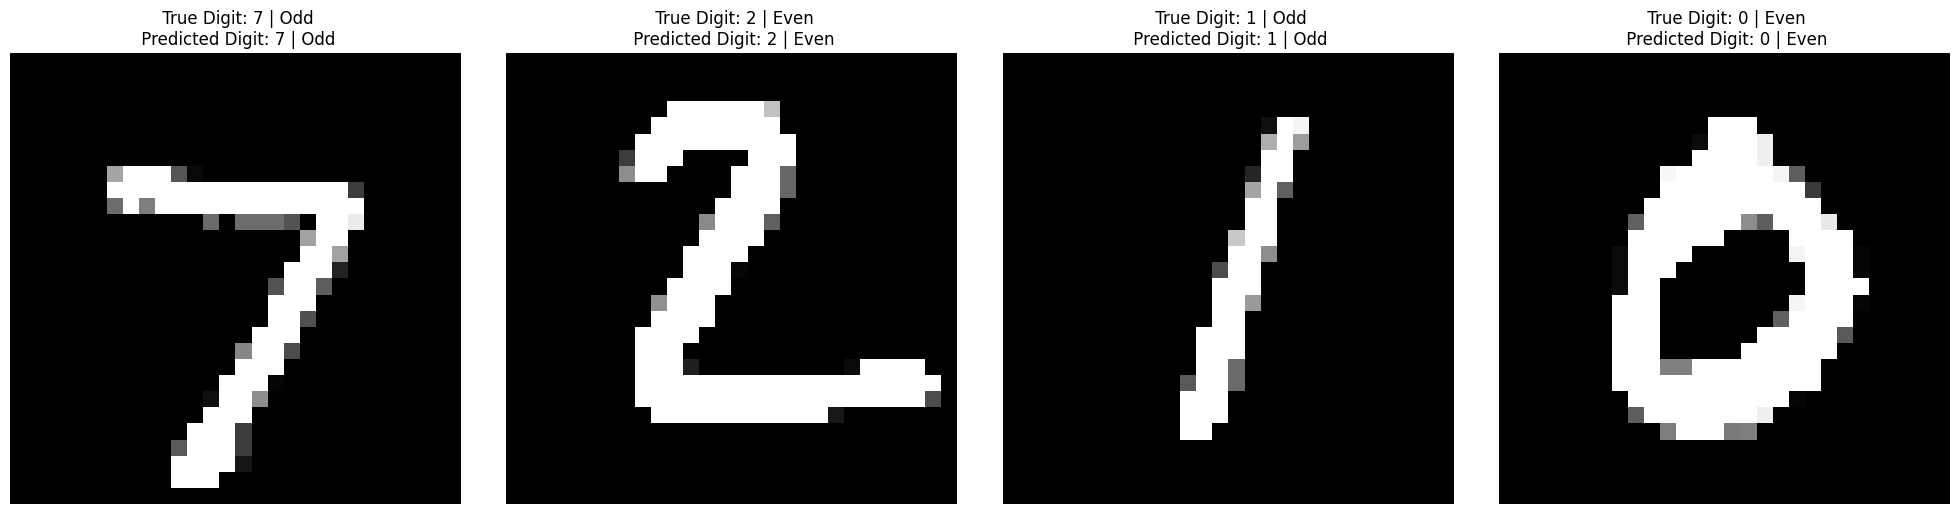

In [6]:
# 🎨 Plot a few test predictions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

model.eval()  # Ensure the model is in evaluation mode

for i in range(4):
    # Get test sample
    image, true_digit, true_even_odd = test_dataset[i]
    image_input = image.unsqueeze(0).to(device)

    # 🔮 Forward pass
    concept_logits, task_logits = model(image_input)

    # Get predicted labels
    predicted_digit = torch.argmax(concept_logits, dim=1).item()
    predicted_task = torch.argmax(task_logits, dim=1).item()

    # 🖼️ Show the image
    axes[i].imshow(image.permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray')
    axes[i].set_title(
        f" True Digit: {true_digit} | {'Odd' if true_even_odd else 'Even'}\n"
        f" Predicted Digit: {predicted_digit} | {'Odd' if predicted_task else 'Even'}",
        fontsize=12
    )
    axes[i].axis("off")

plt.tight_layout()
plt.show()



## 7. 👩🏻‍🔬 Concept Intervention

In this step, we manually intervene on the predicted concepts to study their influence on the final task prediction (even/odd). This allows us to evaluate the **role** of concepts in the model's reasoning process.

![Concept Intervention CBM](https://github.com/cxai-mechint-htutorial-kdd2025/cxai-mechint-htutorial-kdd2025.github.io/blob/main/img_notebooks/cbm_intervention.jpg?raw=true)

We:
- Pick a test image. We will choose it among the ones the model wrongly predicts.
- Force one of the concepts to a chosen value. We will choose the correct one.
- Evaluate the task prediction before and after intervention.

In [7]:
incorrects = []

for i in range(0,500):
  image, true_digit, true_even_odd = test_dataset[i]
  image_input = image.unsqueeze(0).to(device)

  # 🔮 Forward pass
  concept_logits, task_logits = model(image_input)

  # Get predicted labels
  predicted_digit = torch.argmax(concept_logits, dim=1).item()
  predicted_task = torch.argmax(task_logits, dim=1).item()

  if true_even_odd!=predicted_task:
    incorrects.append(i)

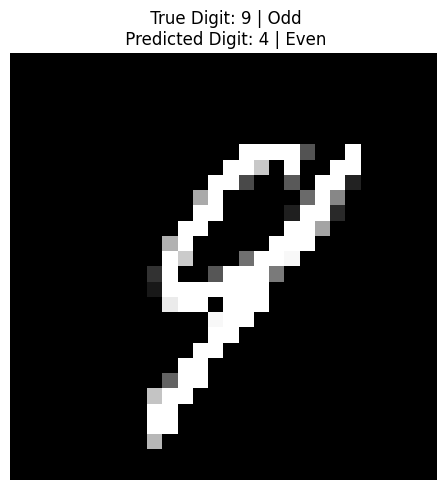

In [8]:
idx = incorrects[0]


# 🎨 Plot a few test predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

model.eval()  # Ensure the model is in evaluation mode

image, true_digit, true_even_odd = test_dataset[idx]
image_input = image.unsqueeze(0).to(device)

# 🔮 Forward pass
concept_logits, task_logits = model(image_input)

# Get predicted labels
predicted_digit = torch.argmax(concept_logits, dim=1).item()
predicted_task = torch.argmax(task_logits, dim=1).item()

# 🖼️ Show the image
ax.imshow(image.permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray')
ax.set_title(
    f" True Digit: {true_digit} | {'Odd' if true_even_odd else 'Even'}\n"
    f" Predicted Digit: {predicted_digit} | {'Odd' if predicted_task else 'Even'}",
    fontsize=12
)
ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
def soft_peak_vector(num_classes: int, peak_index: int, temperature: float = 0.01) -> torch.Tensor:
    """
    Create a softmax vector peaked at `peak_index` with controllable temperature.
    Lower temperature → sharper distribution.
    """
    logits = torch.full((1, num_classes), fill_value=-5.0).to(device)
    logits[0, peak_index] = 5.0
    return logits

# Select the test sample
sample = test_dataset[idx][0].unsqueeze(0).to(device)
_, true_digit, _ = test_dataset[idx]

# Step 1: Predict concepts and task
with torch.no_grad():
    features = model.backbone(sample)
    concept_logits = model.concept_classifier(features)
    concept_logits, task_logits = model(sample)
    predicted_digit = torch.argmax(concept_logits, dim=1).item()
    predicted_task = torch.argmax(task_logits, dim=1).item()

# Show original predictions
print("🔍 Original Prediction:")
print(f" - Predicted Concept: {predicted_digit}")
print(f" - Task Prediction (before intervention): {'Even' if predicted_task == 0 else 'Odd'}")

# Step 2: Intervene: force concept prediction to a different class (e.g., class 2)
intervened_concept_class = true_digit
intervened_logits = soft_peak_vector(num_classes=10, peak_index=intervened_concept_class)

# Step 3: Predict task after intervention
with torch.no_grad():
    task_logits_after = model.task_classifier(intervened_logits)
    task_pred_after = torch.argmax(task_logits_after, dim=1).item()

# Show intervention results
print("\n🧪 After Concept Intervention:")
print(f" - Intervention Applied: Force concept prediction to class {intervened_concept_class}")
print(f" - Task Prediction (after intervention): {'Even' if task_pred_after == 0 else 'Odd'}")


🔍 Original Prediction:
 - Predicted Concept: 4
 - Task Prediction (before intervention): Even

🧪 After Concept Intervention:
 - Intervention Applied: Force concept prediction to class 9
 - Task Prediction (after intervention): Odd
